# Neighborhood Analytics

Given an address of an empty location, what is the best use of the space?

Using the Four Square API and IBM's DSX to create advanced analytics.

In [1]:
!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
import requests 
import pandas as pd 
import numpy as np 
from pandas.io.json import json_normalize

import matplotlib.pyplot as plt
%matplotlib inline

## Make Four Square API Call

#### Set API Credentials

In [2]:
api_url = "https://api.foursquare.com/v2/venues/explore"

params = {'v': '20170513',
          'client_id': "33D0NQYSP2AKAIEEZJNWEPSIU23UAGAXJ1EL0B1J13I4XGHC",
          'client_secret':"ONNNBGVMFHQ3TVUXDVWYVWDDQSZEM42XBO23BUBGC3ZOZ2V0",
          'limit' :50}

#### Convert address to lat, long location

In [3]:
def lat_long(address):
    geolocator = Nominatim()
    location = geolocator.geocode(address)
    longitude, latitude = location.longitude, location.latitude
    print latitude
    print longitude
    return {'ll': '{},{}'.format(latitude, longitude)}

#### Get DataFrame of FourSquare venues near location

In [4]:
def fetch_venues(params, offset=0):
    params.update({'offset':offset})
    response = requests.get(api_url, params=params)
    response.status_code
    venue_data = response.json()
    
    # assign relevant part of JSON to venues
    venues = venue_data["response"]["groups"][0]["items"]
    
    if len(venues) == 0:
        return []
    

    # tranform venues into a dataframe
    dataframe = json_normalize(venues)
    
    # keep only columns that include venue name, url, and anything that is associated with location
    filtered_columns = ['venue.name', 'venue.url', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
    dataframe_filtered = dataframe.ix[:, filtered_columns]

    # function that extracts the category of the venue
    def get_category_type(row):
        try:
            categories_list = row["categories"]
        except:
            categories_list = row["venue.categories"]

        if len(categories_list) == 0:
            return None
        else:
            return categories_list[0]["name"].encode('ascii',errors='ignore')

    # filter the category for each row
    dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

    # clean column names by keeping only last term
    dataframe_filtered.columns = [column.split(".")[-1] for column in dataframe_filtered.columns]
    
    return dataframe_filtered

#### Get Venue Data Around Location for Several Radius Distances

In [5]:
def get_data(radius_list, params):
    '''(list, dict) -> list of DataFrames
    
    Given a list of radius distances, return list of 
    DataFrames of Venues in those areas.
    '''
    df_list = []
    for radius in radius_list:
        params.update({'radius' : radius})
        offset=0
        venues = pd.DataFrame()
        temp = [1]
        #Keep fetching from API until done getting all from Four Square
        while True:
            temp = fetch_venues(params, offset=offset)
            if len(temp) == 0:
                break
            venues = pd.concat([venues, temp])
            offset += 50
        venues.columns = ['name', 'url', 'list', 'id', 'categories']
        df_list.append(venues)
    return df_list

In [6]:
#Add address to params
address = "1218 2nd Ave, New York, NY 10065"
params.update(lat_long(address))

40.7635464
-73.9620774


In [7]:
#Get list of DataFrames
dfs = get_data([500, 1000, 5000], params)

#### Flatten Four Square Categories into Parent Level Venue Categories

In [8]:
#Hash four square categories
cat_list_url = 'https://api.foursquare.com/v2/venues/categories?client_id=33D0NQYSP2AKAIEEZJNWEPSIU23UAGAXJ1EL0B1J13I4XGHC&client_secret=ONNNBGVMFHQ3TVUXDVWYVWDDQSZEM42XBO23BUBGC3ZOZ2V0&v=20170512'

response = requests.get(cat_list_url).json()
cat = response['response']['categories']


# Hashing categories {top_category: [sub categories], ... }
cats = {}
for c in cat:
    top = c['name']
    cats[top] = []
    for sub in c['categories']:
        cats[top].append(sub['name'])

In [9]:
#Encocde each datafraem with parent category
def apply_cat(row):
    #cats = global hash dict
    key_list = cats.keys()
    if row['categories'] in key_list:
        return row['categories']
    for key in cats:
        if row['categories'] in cats[key]:
            return key

### Add Venue Category Metrics

In [10]:
#Add metrics to each df
def add_cat_cols_to_df(df, radius_string):
    '''Returns df with new categories
    columns for plotting'''
    df['parent_cat'] = df.apply(apply_cat, axis=1)
    df['parent_freq'] = df.groupby('parent_cat')['parent_cat'].transform('count')
    non_null_sum = len(df) - df['parent_cat'].isnull().sum()
    df['parent_percent'] = df['parent_freq'] / non_null_sum
    df['radius'] = radius_string
    return df

In [11]:
dfs[0] = add_cat_cols_to_df(dfs[0], '500m')
dfs[1] = add_cat_cols_to_df(dfs[1], '1000m')
dfs[2] = add_cat_cols_to_df(dfs[2], '5000m')

# Visualize Data by Venue Category

In [12]:
!pip install seaborn

In [13]:
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
plt.rcParams['figure.figsize']=(16,8)

In [14]:
all_df = pd.concat([dfs[0], dfs[1], dfs[2]])

In [15]:
#Remove categories not relevant to private land use
all_df = all_df[all_df['parent_cat']!="College & University"]
all_df = all_df[all_df['parent_cat']!="Outdoors & Recreation"]

[<matplotlib.text.Text at 0xdba18d0>, <matplotlib.text.Text at 0xdb15dd8>]

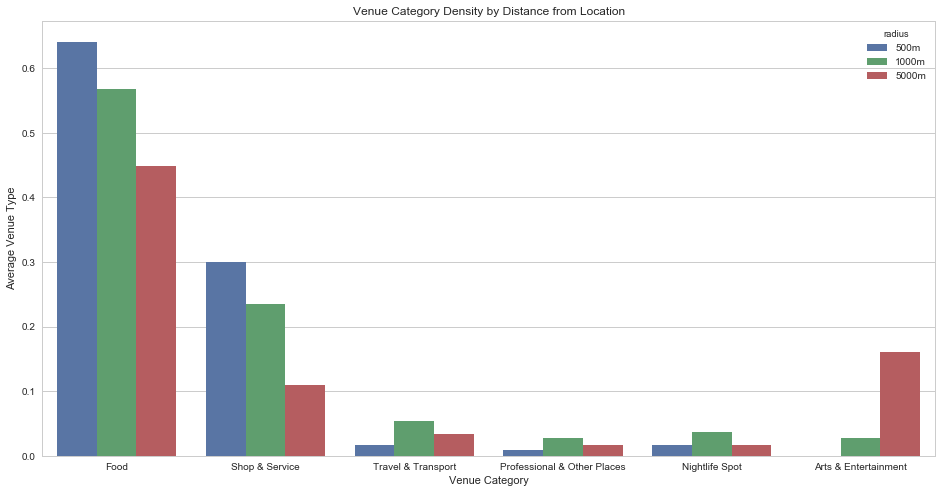

In [16]:
#Create plot
ax = sns.barplot(x="parent_cat", y="parent_percent", hue="radius", data=all_df)
sns.plt.title("Venue Category Density by Distance from Location")
ax.set(xlabel='Venue Category', ylabel='Average Venue Type')

# Visualize by Location Density

In [17]:
!pip install folium

In [18]:
import folium

#Address location
map_nyc = folium.Map(location=[40.7635464,-73.9620774], zoom_start=16)
folium.Marker([40.7635464, -73.9620774], popup = "Location").add_to(map_nyc)

In [19]:
#Get list of nearby venues
def fetch_venues_ll(params, radius=200):
    params.update({'radius': radius}) 
    response = requests.get(api_url, params=params).json()
    totalResults = response['response']['totalResults']
    venues = []
    while len(venues) != totalResults:
        venues.extend(response['response']['groups'][0]['items'])
        params.update({'offset': params.get('offset', 0) + 50})
        response = requests.get(api_url, params=params).json()
    response = requests.get(api_url, params=params).json()

    return venues

In [20]:
#Get nearby venues
params.update({'radius':200})
params.update({'offset':0})
near_by = fetch_venues_ll(params)

In [21]:
#Get data about each nearby location
locations = []

for spot in near_by:
    lat = spot['venue']['location']['lat']
    lon = spot['venue']['location']['lng']
    check_count = spot['venue']['stats']['checkinsCount']
    user_count = spot['venue']['stats']['usersCount']
    loc_cat = spot['venue']['categories'][0]['name']
    #Encode loc_cat into category
    locations.append((lat, lon, check_count, user_count, loc_cat))

In [22]:
def add_point(LAT, LON, CHK, USR, COLOR):
                            folium.CircleMarker([LAT, LON], 
                            popup = 'CheckIn Count: %d\n User Count: %d' % (CHK, USR), #text
                            radius = 9,
                            color = COLOR,
                            fill_color = COLOR,
                            fill_opacity = 0.7).add_to(map_nyc)

#Colorized by category - hardcoded to simply illustrate the point of color coding locations by venue category
for LAT, LON, CHK, USR, CAT in locations:
    if CAT.startswith("Italian"):
        add_point(LAT, LON, CHK, USR, 'blue')
    elif CAT.endswith("Shop"):
        add_point(LAT, LON, CHK, USR, 'red')
    elif "Health" in CAT or "Gym" in CAT or "Dance" in CAT:
        add_point(LAT, LON, CHK, USR, 'yellow')
    elif "Hotel" in CAT:
        add_point(LAT, LON, CHK, USR, 'purple')
    else:
        add_point(LAT, LON, CHK, USR, 'green')

In [23]:
map_nyc

# Next Steps

### Enhancing with Four Square User Data
- Build "home" location of user, see which venues they frequently travel for
- Address user pain points - what venue do they have to travel far for on a regular basis?
- Given "home" location of user, understand neighborhood population beter


### Using Additional Data Sets
- Government Data (Census, Public Records)
- Google Walking Distance


### Public Land - Secondary Use
- Aiding government in deciding best use case for public land
- Addressing community needs